# Context-Aware Aadhaar Update Intelligence Engine (Prototype)

This notebook implements a **full working prototype** of the architecture proposed
in the UIDAI Data Hackathon.

### Key Capabilities
- Privacy-preserving (aggregated data only)
- Behavioral anomaly detection
- Temporal intelligence using LSTM
- Spatial neighborhood analysis
- Unified risk scoring & heatmap visualization

This prototype follows the **official architecture diagram layer by layer**.


In [1]:
!pip install tensorflow scikit-learn seaborn matplotlib pandas numpy


## 1. Environment Setup & Imports

This section loads all libraries required for:
- Data processing
- Machine learning
- Deep learning (Autoencoder + LSTM)
- Visualization


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import NearestNeighbors

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, LSTM, Input


## 2. Aadhaar Open Datasets

We use **aggregated biometric and demographic update data** at:
- Date
- State
- District
- Pincode level

No personal or Aadhaar number data is used.


In [3]:
import os

# ------------------------------------
# Helper function to load multiple files
# ------------------------------------
def load_prefixed_files(folder_path, prefix):
    dfs = []

    for file in os.listdir(folder_path):
        if not file.lower().startswith(prefix.lower()):
            continue

        full_path = os.path.join(folder_path, file)

        if file.endswith(".csv"):
            df = pd.read_csv(full_path)
        elif file.endswith(".xlsx") or file.endswith(".xls"):
            df = pd.read_excel(full_path)
        else:
            continue

        # Standardize column names
        df.columns = df.columns.str.lower().str.strip()

        # Track source file (VERY useful later)
        df["source_file"] = file

        dfs.append(df)

    if not dfs:
        raise ValueError(f"No files found with prefix '{prefix}' in {folder_path}")

    return pd.concat(dfs, ignore_index=True)


# ------------------------------------
# Load ALL biometric* and demographic* files
# ------------------------------------
DATA_FOLDER = "../data"

biometric_df = load_prefixed_files(DATA_FOLDER, "biometric")
demographic_df = load_prefixed_files(DATA_FOLDER, "demographic")

# ------------------------------------
# Robust date parsing (UIDAI-style dates)
# ------------------------------------
biometric_df["date"] = pd.to_datetime(
    biometric_df["date"],
    errors="coerce",
    dayfirst=True
)

demographic_df["date"] = pd.to_datetime(
    demographic_df["date"],
    errors="coerce",
    dayfirst=True
)

# Drop rows where date could not be parsed
biometric_df = biometric_df.dropna(subset=["date"])
demographic_df = demographic_df.dropna(subset=["date"])

print("Biometric rows loaded:", biometric_df.shape)
print("Demographic rows loaded:", demographic_df.shape)


Biometric rows loaded: (1861108, 7)
Demographic rows loaded: (2071700, 7)


## 3. Data Pre-Processing Layer

Steps performed:
- Merge biometric & demographic datasets
- Align dates
- Sort by pincode and time

This corresponds to the **Data Pre-Processing Layer** in the architecture.


In [4]:
df = pd.merge(
    biometric_df,
    demographic_df,
    on=["date", "state", "district", "pincode"],
    suffixes=("_bio", "_demo"),
    how="inner"
)

df = df.sort_values(["pincode", "date"])
df.reset_index(drop=True, inplace=True)

df.head()


,date,state,district,pincode,bio_age_5_17,bio_age_17_,source_file_bio,demo_age_5_17,demo_age_17_,source_file_demo
0,2025-03-01,Delhi,New Delhi,110001,181,159,biometric1.csv,74,437,demographic3.csv
1,2025-03-01,Delhi,New Delhi,110001,181,159,biometric1.csv,74,437,demographic5.csv
2,2025-06-01,Delhi,New Delhi,110001,121,164,biometric1.csv,44,321,demographic3.csv
3,2025-09-01,Delhi,New Delhi,110001,6,4,biometric1.csv,1,10,demographic5.csv
4,2025-09-01,Delhi,Central Delhi,110001,0,2,biometric1.csv,1,3,demographic1.csv


In [5]:
# ======================================================
# INDIA-WIDE STATE CANONICALIZATION (FINAL, COMPLETE)
# ======================================================

import pandas as pd
import re

INDIA_STATE_CANONICAL = {
    # Andhra region
    "andhra pradesh": "Andhra Pradesh",

    # Arunachal & North-East
    "arunachal pradesh": "Arunachal Pradesh",
    "assam": "Assam",
    "manipur": "Manipur",
    "meghalaya": "Meghalaya",
    "mizoram": "Mizoram",
    "nagaland": "Nagaland",
    "tripura": "Tripura",

    # Bihar / Jharkhand
    "bihar": "Bihar",
    "jharkhand": "Jharkhand",

    # Central India
    "chhattisgarh": "Chhattisgarh",
    "madhya pradesh": "Madhya Pradesh",

    # West
    "gujarat": "Gujarat",
    "maharashtra": "Maharashtra",
    "goa": "Goa",
    "rajasthan": "Rajasthan",

    # South
    "karnataka": "Karnataka",
    "kerala": "Kerala",
    "tamil nadu": "Tamil Nadu",
    "telangana": "Telangana",

    # East
    "odisha": "Odisha",
    "orissa": "Odisha",
    "west bengal": "West Bengal",
    "westbengal": "West Bengal",
    "west bangal": "West Bengal",

    # North
    "uttar pradesh": "Uttar Pradesh",
    "uttarakhand": "Uttarakhand",
    "punjab": "Punjab",
    "haryana": "Haryana",
    "himachal pradesh": "Himachal Pradesh",

    # UTs
    "delhi": "Delhi",
    "nct of delhi": "Delhi",
    "chandigarh": "Chandigarh",
    "ladakh": "Ladakh",
    "lakshadweep": "Lakshadweep",

    # Jammu & Kashmir
    "jammu & kashmir": "Jammu & Kashmir",
    "jammu and kashmir": "Jammu & Kashmir",
    "jammukashmir": "Jammu & Kashmir",

    # Andaman & Nicobar
    "andaman & nicobar islands": "Andaman & Nicobar Islands",
    "andaman and nicobar islands": "Andaman & Nicobar Islands",

    # Puducherry
    "puducherry": "Puducherry",
    "pondicherry": "Puducherry",

    # Dadra & Nagar Haveli + Daman & Diu (merged UT)
    "dadra & nagar haveli": "Dadra & Nagar Haveli and Daman & Diu",
    "dadra and nagar haveli": "Dadra & Nagar Haveli and Daman & Diu",
    "daman & diu": "Dadra & Nagar Haveli and Daman & Diu",
    "daman and diu": "Dadra & Nagar Haveli and Daman & Diu",
    "dadra & nagar haveli and daman & diu": "Dadra & Nagar Haveli and Daman & Diu",
    "dadra and nagar haveli and daman and diu": "Dadra & Nagar Haveli and Daman & Diu",
}

def canonicalize_state(state):
    if pd.isna(state):
        return state

    s = str(state).strip().lower()
    s = re.sub(r"\s+", " ", s)

    return INDIA_STATE_CANONICAL.get(s, s.title())


df["state"] = df["state"].apply(canonicalize_state)

print("✅ All Indian states & UTs canonicalized")
print("Unique states after cleanup:", df["state"].nunique())


✅ All Indian states & UTs canonicalized
Unique states after cleanup: 36


In [6]:
sorted(df["state"].unique())



['Andaman & Nicobar Islands',
 'Andhra Pradesh',
 'Arunachal Pradesh',
 'Assam',
 'Bihar',
 'Chandigarh',
 'Chhattisgarh',
 'Dadra & Nagar Haveli and Daman & Diu',
 'Delhi',
 'Goa',
 'Gujarat',
 'Haryana',
 'Himachal Pradesh',
 'Jammu & Kashmir',
 'Jharkhand',
 'Karnataka',
 'Kerala',
 'Ladakh',
 'Lakshadweep',
 'Madhya Pradesh',
 'Maharashtra',
 'Manipur',
 'Meghalaya',
 'Mizoram',
 'Nagaland',
 'Odisha',
 'Puducherry',
 'Punjab',
 'Rajasthan',
 'Sikkim',
 'Tamil Nadu',
 'Telangana',
 'Tripura',
 'Uttar Pradesh',
 'Uttarakhand',
 'West Bengal']

## 4. Feature Engineering Layer

We create **behavioral signals** including:
- Biometric–Demographic ratio
- Age transition skew
- Rolling temporal statistics

These features power all AI models.


In [7]:
print("COLUMNS IN DATAFRAME:")
for col in df.columns:
    print(col)


COLUMNS IN DATAFRAME:
date
state
district
pincode
bio_age_5_17
bio_age_17_
source_file_bio
demo_age_5_17
demo_age_17_
source_file_demo


In [8]:
# -----------------------------
# Feature Engineering (FINAL)
# -----------------------------

# Totals
df["biometric_total"] = df["bio_age_5_17"] + df["bio_age_17_"]
df["demographic_total"] = df["demo_age_5_17"] + df["demo_age_17_"]

# Core behavioral ratio
df["bio_demo_ratio"] = df["biometric_total"] / (df["demographic_total"] + 1)

# Age transition skew
df["age_transition_skew"] = df["bio_age_5_17"] / (df["bio_age_17_"] + 1)

# Temporal rolling features (7-day window)
df["rolling_mean"] = (
    df.groupby("pincode")["bio_demo_ratio"]
      .transform(lambda x: x.rolling(7, min_periods=1).mean())
)

df["rolling_std"] = (
    df.groupby("pincode")["bio_demo_ratio"]
      .transform(lambda x: x.rolling(7, min_periods=1).std().fillna(0))
)

df.head()


,date,state,district,pincode,bio_age_5_17,bio_age_17_,source_file_bio,demo_age_5_17,demo_age_17_,source_file_demo,biometric_total,demographic_total,bio_demo_ratio,age_transition_skew,rolling_mean,rolling_std
0,2025-03-01,Delhi,New Delhi,110001,181,159,biometric1.csv,74,437,demographic3.csv,340,511,0.664062,1.131250,0.664062,0.000000
1,2025-03-01,Delhi,New Delhi,110001,181,159,biometric1.csv,74,437,demographic5.csv,340,511,0.664062,1.131250,0.664062,0.000000
2,2025-06-01,Delhi,New Delhi,110001,121,164,biometric1.csv,44,321,demographic3.csv,285,365,0.778689,0.733333,0.702271,0.066179
3,2025-09-01,Delhi,New Delhi,110001,6,4,biometric1.csv,1,10,demographic5.csv,10,11,0.833333,1.200000,0.735037,0.084936
4,2025-09-01,Delhi,Central Delhi,110001,0,2,biometric1.csv,1,3,demographic1.csv,2,4,0.400000,0.000000,0.668029,0.166915


In [9]:
FEATURE_COLUMNS = [
    "bio_demo_ratio",
    "rolling_mean",
    "rolling_std",
    "age_transition_skew"
]

X = df[FEATURE_COLUMNS].fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## 6. Behavioral Baseline Model (Isolation Forest)

Learns **normal Aadhaar update behavior** and flags deviations.


In [10]:
iso_model = IsolationForest(
    n_estimators=200,
    contamination=0.05,
    random_state=42
)

df["iso_score"] = -iso_model.fit_predict(X_scaled)
df["iso_score"] = (df["iso_score"] + 1) / 2


## 7. Identity Lifecycle Model (Autoencoder)

Captures **normal identity update patterns** and measures reconstruction error.


In [11]:
input_dim = X_scaled.shape[1]

input_layer = Input(shape=(input_dim,))
encoded = Dense(8, activation="relu")(input_layer)
decoded = Dense(input_dim, activation="linear")(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer="adam", loss="mse")

autoencoder.fit(
    X_scaled,
    X_scaled,
    epochs=20,
    batch_size=256,
    verbose=0
)

reconstructed = autoencoder.predict(X_scaled)

df["autoencoder_score"] = np.mean(
    np.square(X_scaled - reconstructed), axis=1
)

df["autoencoder_score"] = (
    df["autoencoder_score"] - df["autoencoder_score"].min()
) / (
    df["autoencoder_score"].max() - df["autoencoder_score"].min()
)


50570/50570 ━━━━━━━━━━━━━━━━━━━━ 38s 751us/step


## 8. Temporal Intelligence (LSTM)

Differentiates **short-term spikes** from **sustained anomalies**.


In [12]:
# ---------------------------------------------------
# Temporal Intelligence (Memory-Safe LSTM - FINAL)
# ---------------------------------------------------

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
import numpy as np

SEQUENCE_LENGTH = 14
MAX_SEQUENCES = 5000   # Prevent memory crash

X_seq = []
y_seq = []
index_map = []

# Build sequences safely
for pincode, group in df.groupby("pincode"):
    series = group["bio_demo_ratio"].values.astype("float32")

    if len(series) <= SEQUENCE_LENGTH:
        continue

    for i in range(len(series) - SEQUENCE_LENGTH):
        X_seq.append(series[i:i + SEQUENCE_LENGTH])
        y_seq.append(series[i + SEQUENCE_LENGTH])
        index_map.append(group.index[i + SEQUENCE_LENGTH])

        if len(X_seq) >= MAX_SEQUENCES:
            break

    if len(X_seq) >= MAX_SEQUENCES:
        break

# Convert to arrays
X_seq = np.array(X_seq).reshape(-1, SEQUENCE_LENGTH, 1)
y_seq = np.array(y_seq).reshape(-1, 1)

print("Sequences used:", X_seq.shape)

# Define lightweight LSTM
lstm_model = Sequential([
    Input(shape=(SEQUENCE_LENGTH, 1)),
    LSTM(8),
    Dense(1)
])

lstm_model.compile(optimizer="adam", loss="mse")

# Train (fast & safe)
lstm_model.fit(
    X_seq,
    y_seq,
    epochs=2,
    batch_size=128,
    verbose=1
)

# Predict & compute temporal anomaly score
preds = lstm_model.predict(X_seq, verbose=0)
errors = np.abs(preds.flatten() - y_seq.flatten())

# Initialize column
df["lstm_score"] = 0.0

# Assign scores back
for idx, err in zip(index_map, errors):
    df.loc[idx, "lstm_score"] = err

# Normalize score to 0–1
df["lstm_score"] = (
    df["lstm_score"] - df["lstm_score"].min()
) / (
    df["lstm_score"].max() - df["lstm_score"].min() + 1e-6
)


Sequences used: (5000, 14, 1)
Epoch 1/2
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.4795
Epoch 2/2
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8859


## 9. Spatial Intelligence

Compares each pincode with its **local neighborhood behavior**.


In [13]:
df["spatial_score"] = 0.0

for date, subset in df.groupby("date"):
    values = subset[["bio_demo_ratio"]].values
    if len(values) < 5:
        continue

    nn = NearestNeighbors(n_neighbors=5).fit(values)
    indices = nn.kneighbors(return_distance=False)

    local_means = np.array([values[idx].mean() for idx in indices])

    df.loc[subset.index, "spatial_score"] = np.abs(
        subset["bio_demo_ratio"].values - local_means
    )
df["spatial_score"] = (
    df["spatial_score"] - df["spatial_score"].min()
) / (
    df["spatial_score"].max() - df["spatial_score"].min()
)


## 10. Risk Scoring Engine

Combines **temporal, spatial, and behavioral signals** into a single risk score.


In [14]:
df["final_risk_score"] = (
    0.3 * df["iso_score"] +
    0.3 * df["autoencoder_score"] +
    0.2 * df["lstm_score"] +
    0.2 * df["spatial_score"]
)

df["risk_level"] = pd.cut(
    df["final_risk_score"],
    bins=[0, 0.4, 0.7, 1],
    labels=["Normal", "Monitor", "High Risk"]
)


## 11. UIDAI / Government Dashboard Outputs

Visual risk heatmap and CSV outputs.


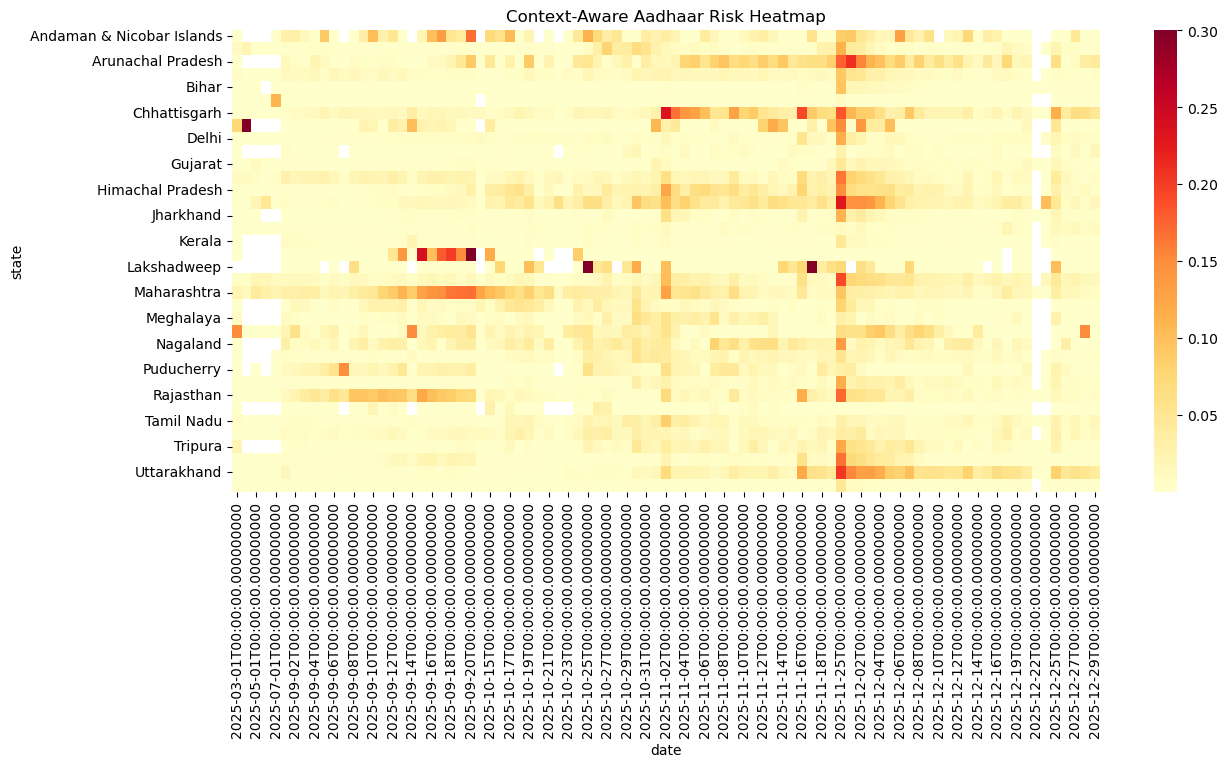

In [15]:
heatmap_data = df.groupby(["state", "date"])["final_risk_score"].mean().unstack()

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap="YlOrRd")
plt.title("Context-Aware Aadhaar Risk Heatmap")
plt.savefig("../plots/heatmap.png", dpi=300)
plt.show()

df.to_csv("../outputs/risk_scores.csv", index=False)
df[df["risk_level"] == "High Risk"].to_csv(
    "../outputs/high_risk_regions.csv", index=False
)


## 12. Explainability Layer (Human-Readable Intelligence)

This layer converts AI risk signals into **clear, interpretable explanations**
that can be understood by UIDAI officers and policy makers.

Instead of only flagging risk, we explain *why* a region is risky.


In [16]:
def generate_explanation(row):
    reasons = []

    if row["bio_demo_ratio"] > 3:
        reasons.append("unusually high biometric-to-demographic update ratio")

    if row["lstm_score"] > 0.7:
        reasons.append("sustained abnormal behavior over time")

    if row["spatial_score"] > 0.6:
        reasons.append("behavior isolated from neighboring regions")

    if row["iso_score"] > 0.7:
        reasons.append("deviation from normal Aadhaar update lifecycle")

    if not reasons:
        return "normal lifecycle behavior"

    return "; ".join(reasons)

df["explanation"] = df.apply(generate_explanation, axis=1)


## 13. Semantic Context Layer

Certain Aadhaar update patterns are expected during:
- School admission seasons
- Biometric refresh cycles
- Government drives

This layer adds **context-awareness** so anomalies are judged fairly.


In [17]:
def assign_semantic_context(date):
    if date.month in [4, 5, 6]:
        return "School admission period"
    elif date.month in [1, 2, 3]:
        return "Biometric refresh cycle"
    elif date.month in [7, 8]:
        return "Monsoon / low mobility period"
    else:
        return "Normal operational period"

df["semantic_context"] = df["date"].apply(assign_semantic_context)


In [18]:
def assign_semantic_context(date):
    if date.month in [4, 5, 6]:
        return "School admission period"
    elif date.month in [1, 2, 3]:
        return "Biometric refresh cycle"
    elif date.month in [7, 8]:
        return "Monsoon / low mobility period"
    else:
        return "Normal operational period"

df["semantic_context"] = df["date"].apply(assign_semantic_context)


## 14. Risk Persistence Score

Single-day anomalies may be noise.
Persistent anomalies indicate **systemic risk**.

This score measures how long high-risk behavior persists.


In [19]:
df["high_risk_flag"] = (df["final_risk_score"] > 0.7).astype(int)

df["risk_persistence"] = (
    df.groupby("pincode")["high_risk_flag"]
      .transform(lambda x: x.rolling(14, min_periods=1).sum())
)


## 15. Early Warning System

This layer detects regions **trending towards high risk**
before they cross the alert threshold.


In [20]:
df["risk_trend"] = df.groupby("pincode")["final_risk_score"].diff(7)

df["early_warning"] = (
    (df["risk_trend"] > 0.15) &
    (df["final_risk_score"] < 0.7)
)


## 16. Synthetic Normal Simulation

To validate anomalies, we compare real behavior
against AI-simulated normal scenarios.

If deviation persists even under simulation,
the anomaly is statistically improbable.


In [21]:
df["simulated_ratio"] = (
    df.groupby("pincode")["bio_demo_ratio"]
      .transform(lambda x: np.random.permutation(x.values))
)

df["simulation_deviation"] = abs(
    df["bio_demo_ratio"] - df["simulated_ratio"]
)


## 17. Enhanced Outputs

Saving enriched outputs including:
- Risk persistence
- Early warning flags
- Explanations
- Semantic context


In [22]:
df.to_csv("../outputs/risk_scores_enriched.csv", index=False)

df[
    (df["risk_level"] == "High Risk") |
    (df["early_warning"])
].to_csv("../outputs/actionable_regions.csv", index=False)
